In this notebook, we shall look at solving the problem of Dynamometer Classification 
useing a TensorFlow based Nueral network.

Test 1:
For a similar type of architecture, what kind of feature intake gives better results:
- Flattened Fourier Descriptors
- Fourier Descriptors as a 2D-matrix (Add a Covolution layer for input)



## Import Libraries

In [1]:
"""
For setting up local imports in an Ipython Shell
This is a workaround for ipython, dont need it for basic python scripts
"""
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [249]:
# General
import pandas as pd
import numpy as np
import itertools

# Geometry
from pyefd import elliptic_fourier_descriptors

# PLotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Feature Engg
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# Local imports
from library import lib_aws, lib_dyna

In [22]:
mpl.rcParams['figure.figsize'] = (15,5)
mpl.rcParams['axes.grid'] = False
plt.style.use('dark_background')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Import Labeled Data

Labeled data is stored in the following DB (This is for Dev, going ahead update it for production) 
```
database = 'oasis-dev'
schema = 'clean'
table = 'dynalabels'
```

In [3]:
"""
Importing the labeled data
Importing the bounds as well: Can help with Normalizing
"""

query = """SELECT * FROM clean.dynalabel ORDER BY "NodeID", "Date";"""
query_bounds = """SELECT * FROM clean.dynabounds;"""

with lib_aws.PostgresRDS(db='oasis-dev') as engine:
    data = pd.read_sql(query, engine, parse_dates=['Date'])
    bounds_df = pd.read_sql(query_bounds, engine)

data.fillna(np.nan, inplace=True)
bounds_df.set_index('index', inplace=True)
well_bounds = bounds_df.T  # Implement this as it will be easier to query going ahead

Connected to oasis-dev DataBase
Connection Closed


## Label Clean-up


We use the `lib_dyna.MultiLabels` to clean up our labels and get more info with regards to them.

In [5]:
# Cleaning the labels and the dataframe
mlabels = lib_dyna.MultiLabels(df=data,
                              card_col='pocdowncard',
                              well_col='NodeID',
                              label_cols=['TrueLabel1', 'TrueLabel2'])

mlabels.remove_errors()  # will remove any erroneous datapointsa and convert the card data into shapely objs
mlabels.merge_labels()  # will merge and organzie the multilabels
print("Label Groups present in the dataset:")
display(mlabels.get_group_counts())

Total errors found in 0 datapoints
Label Groups present in the dataset:


,TrueLabel1,TrueLabel2,totalVal,pctVal
0,Fluid Pound,NA,3344,24.90
1,Full Pump,Wellbore Friction,2079,15.48
2,Gas Interference,NA,1354,10.08
3,Leak in Traveling Valve,NA,1310,9.75
4,Full Pump,NA,1273,9.48
5,Fluid Pound,Leak in Traveling Valve,752,5.60
6,Full Pump,Tubing Movement,743,5.53
7,Fluid Pound,Pump Tagging Up,458,3.41
8,Fluid Pound,Full Pump,400,2.98
9,Gas Interference,Leak in Traveling Valve,313,2.33


In [6]:
thresh = 0.5  # All label gps which are below 0.5% will be dropped
mlabels.remove_labels(thresh=thresh)  # Remove Labels below a threshold

Data has been updated by removing labels below a threshold of 0.5


In [7]:
print("Final Label Groups:")
display(mlabels.get_group_counts())

print("Unique Labels:")
display(mlabels.get_label_counts())

Final Label Groups:


,TrueLabel1,TrueLabel2,totalVal,pctVal
0,Fluid Pound,NA,3344,25.01
1,Full Pump,Wellbore Friction,2079,15.55
2,Gas Interference,NA,1354,10.13
3,Leak in Traveling Valve,NA,1310,9.80
4,Full Pump,NA,1273,9.52
5,Fluid Pound,Leak in Traveling Valve,752,5.63
6,Full Pump,Tubing Movement,743,5.56
7,Fluid Pound,Pump Tagging Up,458,3.43
8,Fluid Pound,Full Pump,400,2.99
9,Gas Interference,Leak in Traveling Valve,313,2.34


Unique Labels:


,totalVal,pctVal
Fluid Pound,5380,40.245
Full Pump,5101,38.158
Gas Interference,2491,18.634
Leak in Traveling Valve,2456,18.372
Wellbore Friction,2079,15.552
Pump Tagging Up,920,6.882
Tubing Movement,743,5.558
Leak in Standing Valve,169,1.264
Excessive Vibration of the Rod,116,0.868


## Feature matrix

**Feature Generation Logic**
- We plan on using FD of these shapely polygons as features (fd_order * 4)
- The features extracted will be a 3D matrix (samples * fd_order * 4)
- As our labels are multi-labels, we are using the Multilabel Binrarizer to encode it.

**Some Additional Parameter we can tune:**
- How we normlaize the xy values before extracting the Fourier Descriptors?
- Order of Fourier descriptors

In [4]:
# Normalizing functions
def well_normalized_fd(poly, wellname, well_bounds_df, fd_order=10):
    """
    Extracts the FD from the shapely polynomial
    Does the transformations
    - poly --> xy
    - xy --> norm_xy (Normalizaing in a well specific basis)
    - norm_xy --> fd
    :param poly: Shapely polygon
    :param wellname: The well this card belongs to
    :param well_bounds_df: A dataframe with well_names as the index 
                          and [pos_min, pos_max, load_min, Load_max] as the columns
    :return: fourier descriptor of the shapely polygon
    """
    xy = np.asarray(poly.exterior.coords)  # convert to xy array
    pmin, pmax, lmin, lmax = well_bounds_df.loc[wellname].values  # get the bounds for that specific well
    
    # normializing
    norm_pos = [((i - pmin) / (pmax - pmin)) for i in xy[:, 0]]  
    norm_load = [((i - lmin) / (lmax - lmin)) for i in xy[:, 1]]
    norm_xy = np.column_stack(([norm_pos, norm_load]))
    
    # get fd (will be a fd_order x 4 array)
    fd = elliptic_fourier_descriptors(norm_xy, order=fd_order, normalize=False)
    return fd

In [8]:
# Basic Setup
test_df = mlabels.df.copy()  # use the clean df from the mlabels class obj
fd_order = 10

In [9]:
%%time
# Using pandas apply get fd array
fd_array = test_df.apply(lambda x: well_normalized_fd(x.pocdowncard, x.NodeID, well_bounds, fd_order=fd_order), axis=1)
fd_array = np.concatenate(fd_array).reshape(len(fd_array), fd_order, 4)

Wall time: 5.94 s


In [10]:
%%time
# Using a for loop
fd_arr = []
for i in test_df.index:
    temp_poly = test_df.loc[i, 'pocdowncard']
    temp_well = test_df.loc[i, 'NodeID']
    temp_fd = well_normalized_fd(temp_poly, temp_well, well_bounds, fd_order=fd_order)
    fd_arr.append(temp_fd)
    
fd_arr = np.array(fd_arr)

Wall time: 5.99 s


In [11]:
"""
Both the apply func and the for loop gave similar results
See if further optimization is possible
"""
# Getting Binarized label values
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(mlabels.merged)
print("Classes encoded:", *mlb.classes_, sep='\n')

Classes encoded:
Excessive Vibration of the Rod
Fluid Pound
Full Pump
Gas Interference
Leak in Standing Valve
Leak in Traveling Valve
Pump Tagging Up
Tubing Movement
Wellbore Friction


In [12]:
# Spliting our dataset
x_train, x_test, y_train, y_test = train_test_split(fd_arr, labels,
                                                    test_size=0.3,
                                                    stratify=labels,
                                                    random_state=42)

# TF Models

In [258]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, LSTM, Dense, Flatten, BatchNormalization, Dropout, MaxPool2D

In [181]:
"""
NN PLotting funtions
"""
def plot_loss(history, label, n):
    # Use a log scale to show the wide range of values.
    plt.plot(history.epoch,  history.history['loss'],
             color=colors[n], label='Train')
    plt.plot(history.epoch,  history.history['val_loss'],
             color=colors[n], label='Val',
             linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(label)
    plt.legend()
    plt.show()
    
def plot_log_loss(history, label, n):
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'],
                 color=colors[n], label='Train')
    plt.semilogy(history.epoch,  history.history['val_loss'],
                 color=colors[n], label='Val',
                 linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss(Logarithmic Scale)')
    plt.title(label)
    plt.legend()
    plt.show()

def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
          plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
          plt.ylim([0.8,1])
        else:
          plt.ylim([0,1])

        plt.legend()


## Sequential Dense Model

**Model details**

Reasoning behind some base params
- Activation: `elu` with `he_normal` as the kernel initializer
- Optmizer 
    - Using `Adam` 
    - `Nadam` may give better results. 
    - Also try `RMSProp` 
    - All the above are Adaptive Gradients
    - However if we notice the model isnt generalizing we could use Nestrov Gradient

### Tune Learning Rate using callbacks

- We are using Exponential scheduling for now. 
- Will depend on epochs and initial lr0
- Try implementing decay based scheduling 
- Try other techniques for scheduling as well

From the plot below we choose the leanring_rate to be 1e-2

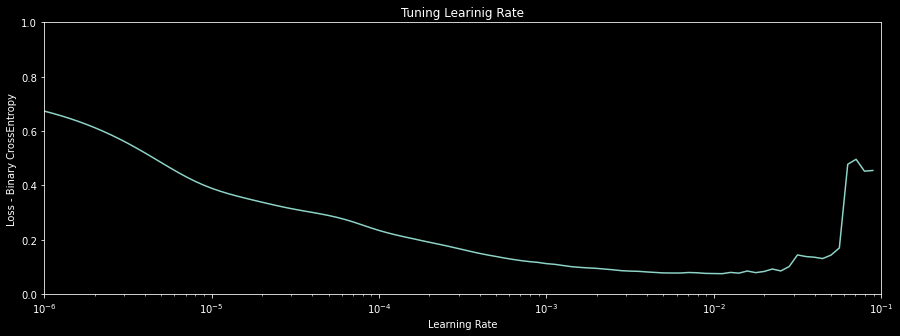

In [147]:
lr0 = 1e-6  # Initial Lr
epochs = 100  # Epochs
lre = 1e-1 # from the fucniton used to schedule lr

# Create a model
tf.keras.backend.clear_session()

model_dense = Sequential([
    Flatten(input_shape=[fd_order, 4]),
#     BatchNormalization(),
    Dense(300, activation="elu", kernel_initializer="he_normal"),
#     BatchNormalization(),
    Dense(100, activation="elu", kernel_initializer="he_normal"),
#     BatchNormalization(),
    Dense(len(mlb.classes_), activation="sigmoid")
])

# Learnining Rate Scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: lr0 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.Adam(lr=lr0)
model_dense.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(),
)

history = model_dense.fit(
    x_train,
    y_train,
    epochs=epochs,
    validation_split=0.2,
    verbose=0,
    callbacks=[lr_schedule]
)

# PLot loss wrt LR
lrs = lr0 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([lr0, lre, 0, 1])
plt.xlabel('Learning Rate')
plt.ylabel('Loss - Binary CrossEntropy')
plt.title("Tuning Learinig Rate")
plt.show()

### Testing Out some Arhitectures

In [241]:
# Params
metrics = [
    keras.metrics.CategoricalAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]

def test_architecture(model, name, epochs=100, val_split=0.2, lr=1e-3, return_model=False):
    # Create a model
    tf.keras.backend.clear_session()
    
    model.compile(
        optimizer=keras.optimizers.Adam(lr=lr),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )

    history = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        validation_split=val_split,
        verbose=0
    )
    
    # Evalute the model
    model_results = model.evaluate(x_test, y_test, verbose=0)
    model_metrics = ["Loss", "Categorical Accuracy", "Precision", "Recall", "AUC"]
    for m, r in zip(model_metrics, model_results): 
        print("{}: {:.2f} %".format(m,r*100))
    
    # PLot Validation Curves
    plot_loss(history, name, n=2)
    plot_log_loss(history, name, n=0)
    
    if return_model is True:
        return model
    else:
        return history

#### Simple Dense

2 Layer Dense model

Loss: 5.92 %
Categorical Accuracy: 85.76 %
Precision: 95.12 %
Recall: 90.77 %
AUC: 99.47 %


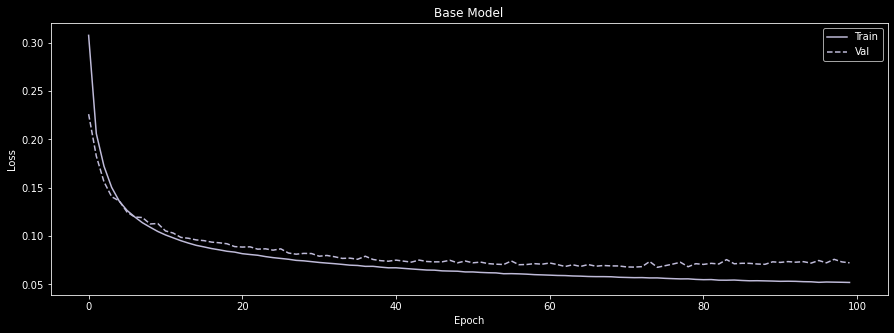

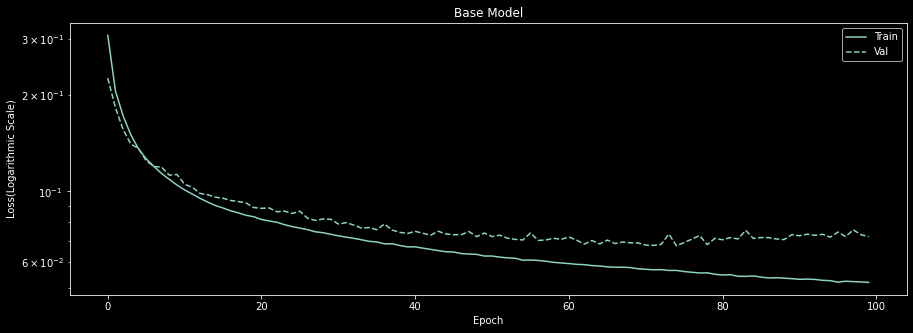

In [218]:
base_model = Sequential([
    Flatten(input_shape=[fd_order, 4]),
    Dense(300, activation="elu", kernel_initializer="he_normal"),
    Dense(100, activation="elu", kernel_initializer="he_normal"),
    Dense(len(mlb.classes_), activation="sigmoid")
])

base_history = test_architecture(base_model, 'Base Model', epochs=100)

#### With Batch Normalization 

Loss: 4.85 %
Categorical Accuracy: 78.71 %
Precision: 94.67 %
Recall: 94.00 %
AUC: 99.65 %


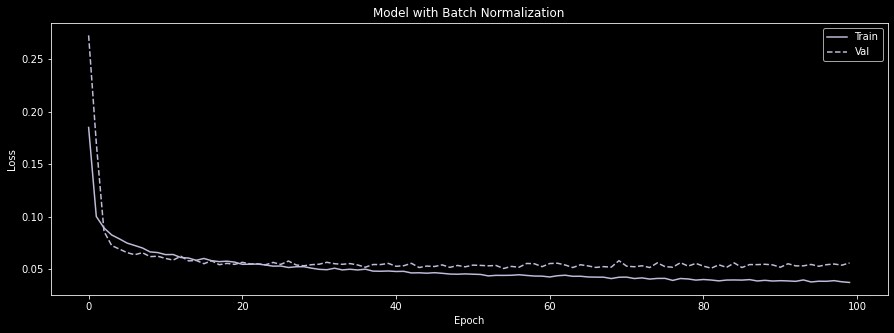

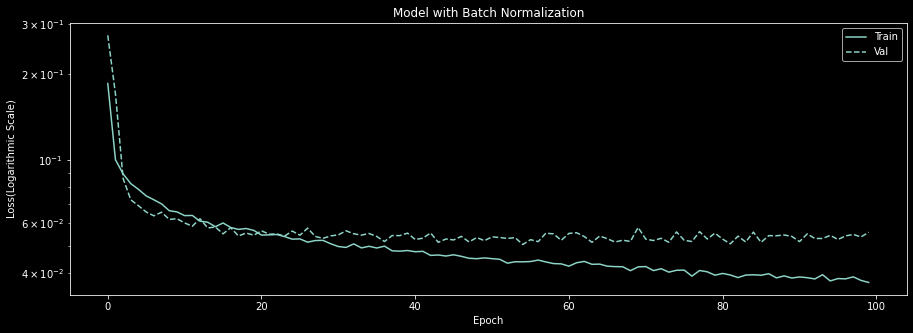

In [220]:
# Normalizing only 1st layer
batch_model = Sequential([
    Flatten(input_shape=[fd_order, 4]),
    BatchNormalization(),
    Dense(300, activation="elu", kernel_initializer="he_normal"),
    Dense(100, activation="elu", kernel_initializer="he_normal"),
    Dense(len(mlb.classes_), activation="sigmoid")
])

batch_history = test_architecture(batch_model, 'Model with Batch Normalization', epochs=100)

Loss: 5.10 %
Categorical Accuracy: 78.61 %
Precision: 94.85 %
Recall: 93.42 %
AUC: 99.60 %


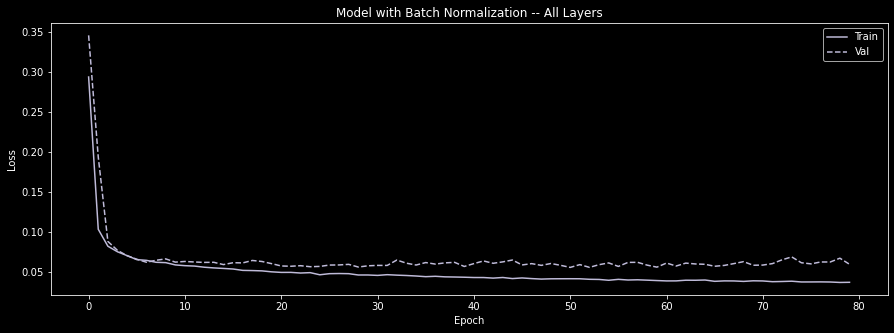

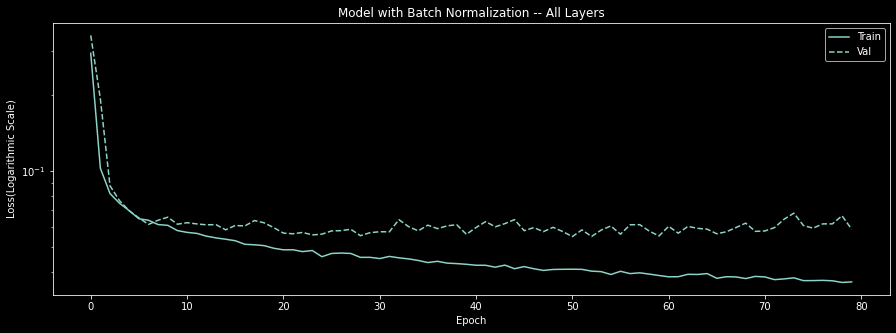

In [221]:
# Normalizing Every Layer
full_batch_model = Sequential([
    Flatten(input_shape=[fd_order, 4]),
    BatchNormalization(),
    Dense(300, activation="elu", kernel_initializer="he_normal"),
    BatchNormalization(),
    Dense(100, activation="elu", kernel_initializer="he_normal"),
    BatchNormalization(),
    Dense(len(mlb.classes_), activation="sigmoid")
])

full_batch_history = test_architecture(full_batch_model, 'Model with Batch Normalization -- All Layers', epochs=80)

#### Adding Dropout 

- We can see there is a hint of overfitting 
- Adding Dropout to Regularize

**Other techniques to implement**
- l1 Regularixation
- MonteCarlo Dropout
- Self Normalizing 

Loss: 5.21 %
Categorical Accuracy: 75.17 %
Precision: 94.43 %
Recall: 91.81 %
AUC: 99.65 %


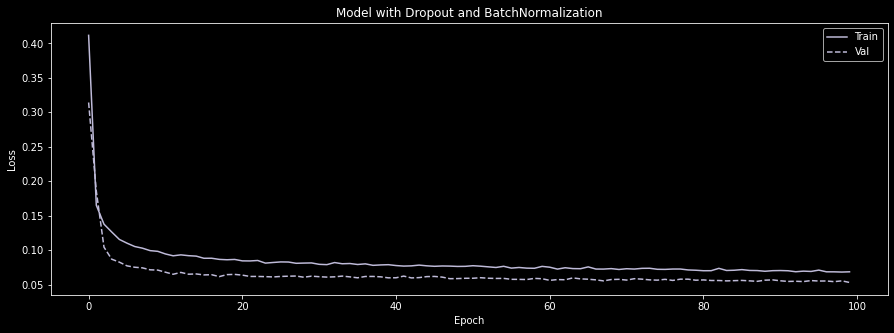

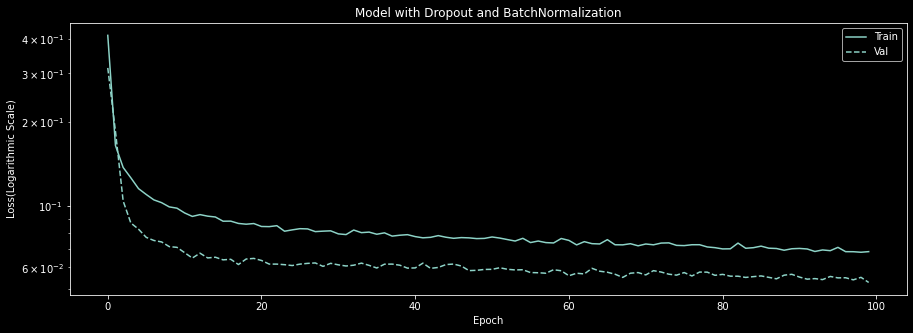

In [222]:
drop_batch_model = Sequential([
    Flatten(input_shape=[fd_order, 4]),
    BatchNormalization(),
    Dropout(0.2),
    Dense(300, activation="elu", kernel_initializer="he_normal"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(100, activation="elu", kernel_initializer="he_normal"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(len(mlb.classes_), activation="sigmoid")
])

drop_batch_history = test_architecture(drop_batch_model, 'Model with Dropout and BatchNormalization', epochs=100)

Loss: 5.32 %
Categorical Accuracy: 76.49 %
Precision: 93.83 %
Recall: 92.24 %
AUC: 99.64 %


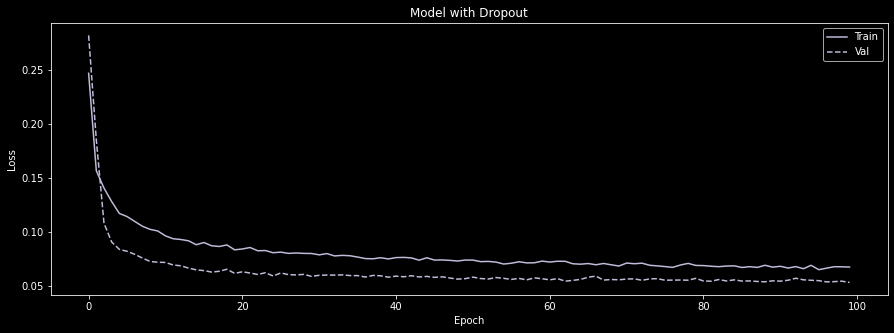

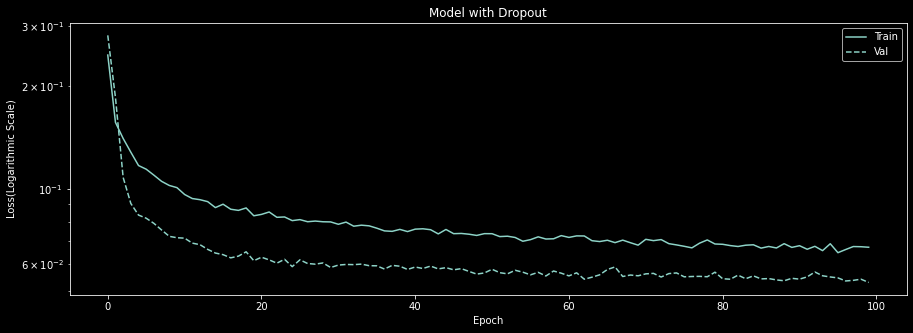

In [223]:
# Only Dropout
drop_model = Sequential([
    Flatten(input_shape=[fd_order, 4]),
    BatchNormalization(),
    Dropout(0.2),
    Dense(300, activation="elu", kernel_initializer="he_normal"),
    Dropout(0.2),
    Dense(100, activation="elu", kernel_initializer="he_normal"),
    Dropout(0.2),
    Dense(len(mlb.classes_), activation="sigmoid")
])

drop_history = test_architecture(drop_model, 'Model with Dropout', epochs=100)

###  Dense Model Metrics

In [250]:
# Imports
from sklearn.metrics import precision_recall_fscore_support, f1_score, recall_score, precision_score
from sklearn.metrics import jaccard_score, hamming_loss, classification_report, confusion_matrix

In [225]:
"""
Classes which help with metrics
"""
class BaselineMetrics:
    
    def __init__(self, y_true, y_pred, labels=None):
        self.true = y_true
        self.pred = y_pred
        self.labels = labels
        
    def base_metrics(self):
        # Weighted
        sc = np.array(precision_recall_fscore_support(self.true, self.pred, average='weighted'), \
                      dtype=np.float32).round(4) * 100
        print('Weighted Metrics')
        print('Precision : {:.2f}\nRecall: {:.2f}\nF-score: {:.2f}'.format(sc[0], sc[1], sc[2]))
        
        # macro
        print('\nMacro Metrics')
        sc_macro = np.array(precision_recall_fscore_support(self.true, self.pred, average='macro'), \
                            dtype=np.float32).round(4) * 100
        print('Precision : {:.2f}\nRecall: {:.2f}\nF-score: {:.2f}'.format(sc_macro[0], sc_macro[1], sc_macro[2]))
        
        # Classification Report
        print("\nClassification Report")
        print(classification_report(self.true, self.pred, target_names = self.labels))
        return None
    
    def label_specific_metrics(self):
        """
        Gives label Specific Metrics
        """

        self.label_metrics = pd.DataFrame(data={
            'Jaccard Score': jaccard_score(self.true, self.pred, average=None),
            'Precision': precision_score(self.true, self.pred, average=None),
            'Recall': recall_score(self.true, self.pred, average=None),
            'F1-Score': f1_score(self.true, self.pred, average=None)
        }).round(2)

        if self.labels is not None:
            self.label_metrics.loc[:, 'Labels'] = self.labels
            self.label_metrics.set_index('Labels', inplace=True)
        
        print("\n Label Specific Metrics:")
        print(self.label_metrics)
        return None
  
    def averaged_scores(self):
        """
        Gives averaged out scores
        """
        metric_types = ['weighted', 'macro', 'micro', 'samples']
        self.avg_metrics = pd.DataFrame(index=['Precision', 'Recall', 'F-Score', 'Jaccard-Score'], columns=metric_types)

        for types in metric_types:
            mt = list(precision_recall_fscore_support(self.true, self.pred, average=types))
            mt = [i for i in mt if i]  # Remove nan
            mt.append(jaccard_score(self.true, self.pred, average=types))

            self.avg_metrics.loc[:, types] = mt

        self.avg_metrics = self.avg_metrics * 100
        self.avg_metrics = self.avg_metrics.round(2)
        print("\n Averaged Metrics:")
        print(self.avg_metrics)
        return None

Loss: 4.68 %
Categorical Accuracy: 77.49 %
Precision: 95.96 %
Recall: 93.10 %
AUC: 99.63 %


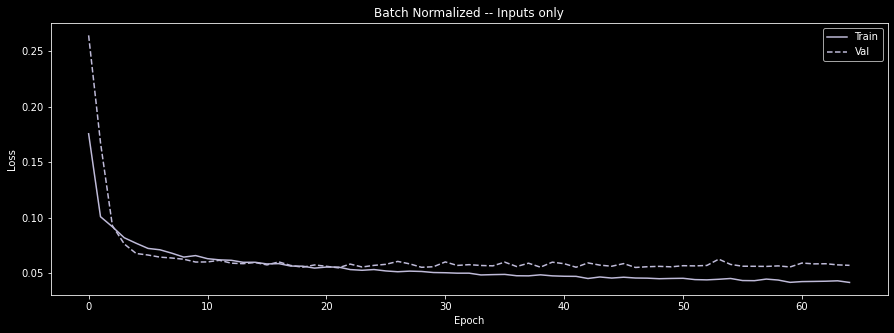

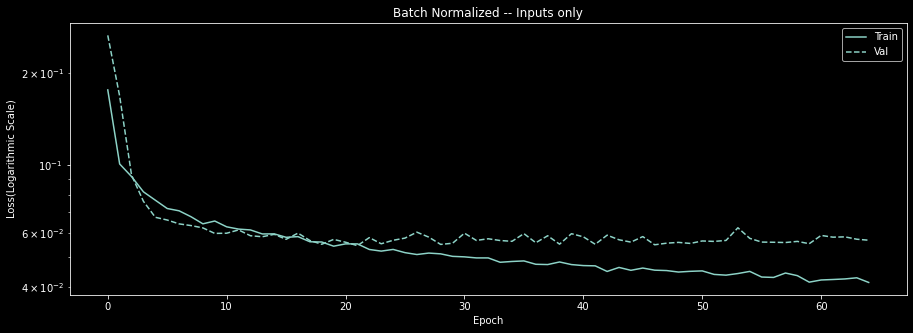

In [247]:
# Choosing the batch model for metrics
# Normalizing only 1st layer
batch_model = Sequential([
    Flatten(input_shape=[fd_order, 4]),
    BatchNormalization(),
    Dense(300, activation="elu", kernel_initializer="he_normal"),
    Dense(100, activation="elu", kernel_initializer="he_normal"),
    Dense(len(mlb.classes_), activation="sigmoid")
])

trained_model = test_architecture(batch_model, 'Batch Normalized -- Inputs only', epochs=65, val_split=0.2, lr=1e-3, return_model=True)

In [248]:
# predictions
y_hat = trained_model.predict(x_test)
thresh=0.5  # threshold for probabilities, TODO optmize this using F1-score and/or ROC Curve
y_pred = tf.cast(tf.greater(y_hat, 0.5), tf.float32)

# Metrics from BaselineMetrics Class
dense_metrics = BaselineMetrics(y_test, y_pred, mlb.classes_)
dense_metrics.base_metrics()
dense_metrics.label_specific_metrics()
dense_metrics.averaged_scores()

# Confusion Matrix

Weighted Metrics
Precision : 95.93
Recall: 93.10
F-score: 94.40

Macro Metrics
Precision : 94.59
Recall: 86.54
F-score: 89.72

Classification Report
                                precision    recall  f1-score   support

Excessive Vibration of the Rod       1.00      0.83      0.91        35
                   Fluid Pound       0.97      0.92      0.95      1614
                     Full Pump       0.98      0.94      0.96      1531
              Gas Interference       0.94      0.98      0.96       748
        Leak in Standing Valve       0.89      0.48      0.62        50
       Leak in Traveling Valve       0.92      0.91      0.92       737
               Pump Tagging Up       0.89      0.76      0.82       276
               Tubing Movement       0.93      0.97      0.95       223
             Wellbore Friction       1.00      1.00      1.00       624

                     micro avg       0.96      0.93      0.95      5838
                     macro avg       0.95      0.87      

c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## CNN

For a CNN, the input shape should be as follows: 

`(<number of data-points>, <image x_dim>, <image y_dim>, <number of channels>)`

Currently we are using a FD order of 10, which would give us a matrix of
`10 x 4` for describing the dynamometer cards

In [262]:
# Will have to reshape the features 
x_train_cnn = x_train.reshape(-1, fd_order, 4, 1)
x_test_cnn = x_test.reshape(-1, fd_order, 4, 1)

In [267]:
x_train_cnn.shape

(9357, 10, 4, 1)

In [286]:
tf.keras.backend.clear_session()

cnn_model = Sequential([
#     tf.keras.layers.InputLayer(input_shape=[10,4,1]),
    Conv2D(32, 7, activation="relu", padding="same", input_shape=[10, 4, 1]),
    MaxPool2D(2),
    Conv2D(64, 3, activation="relu", padding="same"),
    Conv2D(64, 3, activation="relu", padding="same"),
    MaxPool2D(2),
    Conv2D(128, 3, activation="relu", padding="same"),
    Conv2D(128, 3, activation="relu", padding="same"),
    MaxPool2D(2),
    Flatten(),
#     Dense(64, activation="relu"),
#     Dropout(0.5),
#     Dense(32, activation="relu"),
#     Dropout(0.5),
    Dense(len(mlb.classes_), activation="sigmoid")
])

cnn_model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics
)

cnn_history = cnn_model.fit(
    x_train_cnn,
    y_train,
    epochs=100,
#     batch_size=512,
    validation_split=0.2,
    verbose=0
)

ValueError: Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling2d_2/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](conv2d_4/Relu)' with input shapes: [?,2,1,128].

Loss: 5.30 %
Categorical Accuracy: 86.69 %
Precision: 95.52 %
Recall: 91.98 %
AUC: 99.59 %


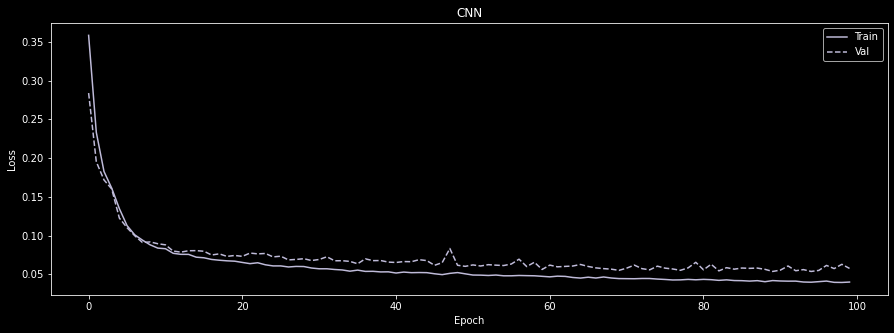

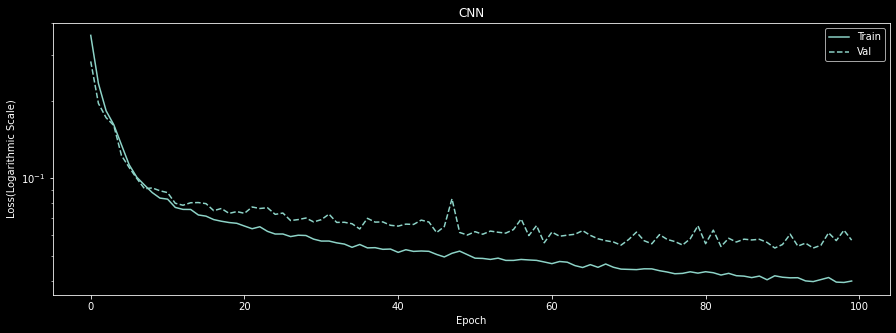

In [284]:
# Evalute the model
cnn_model_results = cnn_model.evaluate(x_test_cnn, y_test, verbose=0)
model_metrics = ["Loss", "Categorical Accuracy", "Precision", "Recall", "AUC"]
for m, r in zip(model_metrics, cnn_model_results): 
    print("{}: {:.2f} %".format(m,r*100))

# PLot Validation Curves
plot_loss(cnn_history, 'CNN', n=2)
plot_log_loss(cnn_history, 'CNN', n=0)

In [285]:
# predictions
y_hat = cnn_model.predict(x_test_cnn)
thresh=0.5  # threshold for probabilities, TODO optmize this using F1-score and/or ROC Curve
y_pred = tf.cast(tf.greater(y_hat, 0.5), tf.float32)

# Metrics from BaselineMetrics Class
cnn_metrics = BaselineMetrics(y_test, y_pred, mlb.classes_)
cnn_metrics.base_metrics()
cnn_metrics.label_specific_metrics()
cnn_metrics.averaged_scores()

Weighted Metrics
Precision : 95.61
Recall: 91.98
F-score: 93.71

Macro Metrics
Precision : 91.47
Recall: 88.76
F-score: 90.00

Classification Report
                                precision    recall  f1-score   support

Excessive Vibration of the Rod       0.97      0.94      0.96        35
                   Fluid Pound       0.98      0.92      0.94      1614
                     Full Pump       0.97      0.95      0.96      1531
              Gas Interference       0.96      0.92      0.94       748
        Leak in Standing Valve       0.74      0.64      0.69        50
       Leak in Traveling Valve       0.95      0.85      0.89       737
               Pump Tagging Up       0.77      0.82      0.79       276
               Tubing Movement       0.90      0.96      0.93       223
             Wellbore Friction       1.00      1.00      1.00       624

                     micro avg       0.96      0.92      0.94      5838
                     macro avg       0.91      0.89      

c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Older metrics

In [70]:
# Evalute the model
model_results = model_dense.evaluate(x_test, y_test, verbose=0)
model_metrics = ["Loss", "Categorical Accuracy", "Precision", "Recall", "AUC"]
for m, r in zip(model_metrics, model_results): 
    print("{}: {:.2f} %".format(m,r*100))

Loss: 4.69 %
Categorical Accuracy: 75.32 %
Precision: 95.50 %
Recall: 94.11 %
AUC: 99.67 %


In [115]:
# predictions
y_hat = model_dense.predict(x_test)
thresh=0.5  # threshold for probabilities, TODO optmize this using F1-score 
y_pred = tf.cast(tf.greater(y_hat, 0.5), tf.float32)

# Metrics from BaselineMetrics Class
dense_metrics = BaselineMetrics(y_test, y_pred, mlb.classes_)
dense_metrics.base_metrics()
dense_metrics.label_specific_metrics()
dense_metrics.averaged_scores()

Weighted Metrics
Precision : 95.53
Recall: 94.11
F-score: 94.80

Macro Metrics
Precision : 90.73
Recall: 91.34
F-score: 90.94

Classification Report
                                precision    recall  f1-score   support

Excessive Vibration of the Rod       0.81      0.97      0.88        35
                   Fluid Pound       0.97      0.94      0.95      1614
                     Full Pump       0.96      0.96      0.96      1531
              Gas Interference       0.97      0.94      0.96       748
        Leak in Standing Valve       0.75      0.72      0.73        50
       Leak in Traveling Valve       0.94      0.91      0.92       737
               Pump Tagging Up       0.84      0.87      0.86       276
               Tubing Movement       0.93      0.91      0.92       223
             Wellbore Friction       1.00      1.00      1.00       624

                     micro avg       0.95      0.94      0.95      5838
                     macro avg       0.91      0.91      

# WorkBook

In [84]:
i=1100
test_card = test_df.loc[i, 'pocdowncard']
test_well = test_df.loc[i, 'NodeID']
test_xy = np.asarray(test_card.exterior.coords)
norm_xy = well_specific_normalization(test_card, test_well, well_bounds)
test_fd = elliptic_fourier_descriptors(norm_xy, order=10, normalize=False)

In [106]:
test_fd = well_normalized_fd(test_card, test_well, well_bounds)
test_fd

array([[-0.25219033,  0.18463414, -0.21485016, -0.19865958],
       [ 0.02457605,  0.01441654, -0.01531473, -0.02678499],
       [-0.03136367, -0.00103164, -0.01272929,  0.01374998],
       [-0.00204893, -0.01720079,  0.00269124,  0.01073091],
       [-0.00096176,  0.01100123, -0.01123133, -0.01073845],
       [-0.00372892,  0.00435309,  0.00187399, -0.00612797],
       [-0.00083225, -0.00102129, -0.00340332,  0.00193784],
       [-0.00225338, -0.00068439,  0.00561365,  0.00177649],
       [-0.00081216, -0.00197633, -0.00142654,  0.0022273 ],
       [ 0.00219576,  0.00273422, -0.00413345, -0.00072186]])

(10, 10, 4)

In [129]:
fd_arr[1,:,:]

array([[-2.71881399e-01,  2.24030435e-01, -2.11542718e-01,
        -2.56377659e-01],
       [-5.26248786e-03, -3.41297978e-04, -1.20754537e-03,
         3.09806787e-03],
       [-1.42742537e-02, -2.17689020e-02, -3.23741299e-02,
         1.68215160e-02],
       [-1.98021029e-03,  3.14300755e-03,  1.24580424e-03,
        -5.38304035e-05],
       [-1.07707969e-02,  6.29237293e-03, -4.07757551e-03,
        -1.28308388e-02],
       [-1.51514377e-03, -7.14422162e-05, -1.06414081e-03,
         1.58247930e-03],
       [ 1.03624589e-03, -4.08499008e-03, -6.07878753e-03,
        -4.87409427e-04],
       [-2.04542303e-03,  2.56796496e-03,  8.45618026e-04,
         4.66147343e-04],
       [-3.76716285e-03,  4.17950839e-04,  1.43748137e-03,
        -4.15109160e-03],
       [ 7.65540065e-04,  7.62167710e-04, -1.48819018e-03,
         8.76530503e-04]])

In [124]:
test_df.shape

(13368, 5)